In [27]:
import sys, os
sys.path.append(os.path.realpath("/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages"))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats

import tsfresh

from os import path

reload(read)

edfRawData = read.EdfDataset("train", "01_tcp_ar", n_process=7, filter=False)

In [22]:
res = read.getAgesAndFileNames("train", "01_tcp_ar")
singAges = [datum[1] for datum in res]
fn = [datum[0] for datum in res]
ages = []
#associate first token file with each session for now
tokenFiles = []
for i, session_file in enumerate(fn):
    session_dir = path.dirname(session_file)
    session_tkn_files = read.get_token_file_names(session_dir)
    session_tkn_files.sort()
    tokenFiles += (session_tkn_files)
    ages += [singAges[i] for j in session_tkn_files]
edfRawData.edf_tokens=tokenFiles

In [28]:
class HandEngineeredDataset(util_funcs.MultiProcessingDataset):
    # ndim = None
    # shape = None
    def __init__(self, edfRawData, n_process=None, features = [], f_names = [], max_size=None, vectorize=None):
        assert len(features) == len(f_names)
        self.edfRawData = edfRawData
        self.n_process = n_process
        if n_process is None:
            self.n_process = mp.cpu_count()
        self.features = features
        self.f_names = f_names
        self.max_size = max_size
        self.vectorize = vectorize
        # self.shape = np.asarray(self[0][0]).shape
        # self.ndim = len(self.shape)
        # self.shape = (len(self), *self.shape)

    def __len__(self):
        return len(self.edfRawData)

    def __getitem__(self, i):
        if type(i) == slice:
            return self.getItemSlice(i)
        fftData, ann = self.edfRawData[i]
        if self.max_size is not None and max(fftData.index) < self.max_size:
            fftData = fftData[:self.max_size]
        handEngineeredData = pd.DataFrame(index=fftData.columns, columns=self.f_names)
        
        for i, feature in enumerate(self.features):
            handEngineeredData[self.f_names[i]] = fftData.apply(lambda x: feature(x))
        if self.vectorize == "full":
            return handEngineeredData.values.reshape(-1)
        if self.vectorize == "mean":
            return handEngineeredData.values.mean()
        return handEngineeredData

In [4]:
def norm_num_peaks_func(n):
    return lambda x: feats.number_peaks(x, n) / len(x)

def norm_num_vals_func(n):
    return lambda x: feats.number_peaks(-x, n) / len(x)



In [48]:
hedDf = HandEngineeredDataset(edfRawData, vectorize=None, max_size=pd.Timedelta(minutes=2), n_process = 4, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20)], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys"])
hed = HandEngineeredDataset(edfRawData, vectorize="mean", max_size=pd.Timedelta(minutes=2), n_process = 4, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20)], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys"])

In [45]:
datum = hedDf[0]

In [50]:
# import pdb; pdb.set_trace()
allHandEngineeredData = hed[:100]


Starting 4 processes
retrievings: 0
retrievings: 5
retrievings: 10
retrievings: 15
retrievings: 20
retrievings: 25
retrievings: 30
retrievings: 35
retrievings: 40
retrievings: 45
retrievings: 50
retrievings: 55
retrievings: 60
retrievings: 65
retrievings: 70
retrievings: 75
retrievings: 80
retrievings: 85
retrievings: 90
retrievings: 95
Process completed
Process completed
Process completed
Process completed


In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
lr = LinearRegression()

In [52]:
sum([type(datum) == int for datum in allHandEngineeredData])

0

In [54]:
trainData = (mm.fit_transform(np.stack(allHandEngineeredData[0:50])))
testData = (mm.fit_transform(np.stack(allHandEngineeredData[50:100])))
testAges = (np.array(ages[50:100]).reshape(-1,1))
trainAges = (np.array(ages[0:50]).reshape(-1,1))
trainData.shape

(50, 105)

In [ ]:
np.isnan(trainData).any().any(), np.isnan(trainData).any().any()

In [68]:
feat_sel = chi2(trainData, trainAges)[1] < 0.5
# feat_sel = slice(-1)

In [73]:
lr.fit(trainData[:], trainAges)
y_pred = lr.predict(testData[:])
y_pred[y_pred < 20] = 20
y_pred[y_pred > 90] = 90
r2_score(y_pred, testAges)

-3.4431766860537323

Text(0, 0.5, 'Actual')

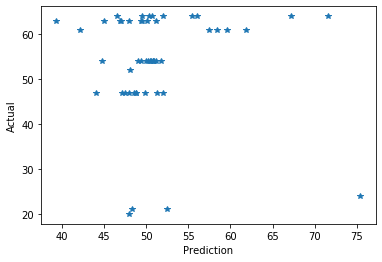

In [75]:
plt.plot(y_pred, testAges, "*")
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [49]:
testAges.mean()

AttributeError: 'list' object has no attribute 'mean'